# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics and Twitter descriptions for the two artists you selected in Module 1. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 
from matplotlib import pyplot as plt

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [2]:
# Use this space for any additional import statements you need
import glob


In [3]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country] : 
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_words = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    
    """
    
    # Fill in the correct values here. 
    num_tokens = len(tokens)
    num_unique_tokens = len(Counter(tokens).keys())
    lexical_diversity = round((num_unique_tokens/num_tokens),2) # Rounded to 2 Digits to match format of existing decimal rounding below
    num_characters = sum(len(i) for i in tokens)
    most_common = Counter(tokens).most_common(num_words)
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        print(f"The most common tokens are {most_common}.")
        
    return


    
def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stop(tokens) :
    tokens = [file for file in tokens if file not in sw]
    return(tokens)
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    text = [file.lower().strip() for file in text.split()]

    return(text)

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [4]:
# Feel free to use the below cells as an example or read in the data in a way you prefer

data_location = "/Users/katiehu/Documents/GitHub/ADS509-Module3/"
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}


In [5]:
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

In [6]:
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

In [7]:
# Insert Lyrics Data Here

lyrics_path = f"{data_location}/{lyrics_folder}"

lyrics = defaultdict(dict)
for file in os.listdir(lyrics_path):
    if os.path.isdir(lyrics_path + file):
        for lyric_page in os.listdir(lyrics_path + file):
            artist,song = lyric_page.split("_")
            song = song.replace(".txt", "")
            lyrics[file][song] = open(lyrics_path + file + "/" + lyric_page).read()


lyrics_list = []
for artist in lyrics:
    for song, lyric in lyrics[artist].items():
        lyrics_dict = {'artist': artist, 'song': song, 'lyrics': lyric}
        lyrics_list.append(lyrics_dict)

lyrics_data = pd.DataFrame.from_dict(lyrics_list)
lyrics_data


,artist,song,lyrics
0,robyn,includemeout,"""Include Me Out""\n\n\n\nIt is really very simp..."
1,robyn,electric,"""Electric""\n\n\n\nElectric...\n\nIt's electric..."
2,robyn,beach2k20,"""Beach 2K20""\n\n\n\n(So you wanna go out?\nHow..."
3,robyn,lovekills,"""Love Kills""\n\n\n\nIf you're looking for love..."
4,robyn,timemachine,"""Time Machine""\n\n\n\nHey, what did I do?\nCan..."
...,...,...,...
415,cher,takeitfromtheboys,"""Take It From The Boys""\n\n\n\nSo scared I nev..."
416,cher,dreambaby,"""Dream Baby""\n\n\n\nI found the boy for me\nHe..."
417,cher,pleasedonttellme,"""Please Don't Tell Me""\n\n\n\nYa shook the ove..."
418,cher,ihopeyoufindit,"""I Hope You Find It""\n\n\n\nThese clouds aren'..."


## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [8]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

lyrics_data["tokens"] = lyrics_data["lyrics"].apply(prepare,pipeline=my_pipeline)
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len) 

twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len) 


In [9]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [10]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
378300,cher,American Born/Salvadoran rooted. G8TFul 4 Scie...,"[american, bornsalvadoran, rooted, g8tful, 4, ..."
1304145,cher,"Scorpio sun, Sagittarius rising, and Aries moo...","[scorpio, sun, sagittarius, rising, aries, moo..."
207412,robyn,"I am not a word, free, I am not a line, young,...","[word, free, line, young, girl, could, ever, d..."
135941,robyn,University of Pittsburgh | EMS-MVFC1🚑,"[university, pittsburgh, emsmvfc1🚑]"
413561,cher,🪱,[🪱]
677398,cher,"❤️Studio Ghibli, Disney, Pixar, DC, MARVEL. Mi...","[❤️studio, ghibli, disney, pixar, dc, marvel, ..."
3952367,cher,Fruit Stand te📱⌚️ch Specialist 🧃| All opinions...,"[fruit, stand, te📱⌚️ch, specialist, 🧃, opinions]"
270619,cher,What’s with this girl? She have beer flavoured...,"[what’s, girl, beer, flavoured, nipples, theyt..."
514719,cher,"Amo minha vida, e as pessoas que nela estão. 💞...","[amo, minha, vida, e, pessoas, que, nela, estã..."
1662946,cher,Football Watcher...😎,"[football, watcher😎]"


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: Some things that could be improved after immediately seeing the tokenization is that while punctuation is removed, the words are just joined together instead of tokenizing of words with the punctuation. For example, `Unicorn|photographer|dancer|music/retro lover|` ran through the pipeline turned into this `unicornphotographerdancermusicretro`. So, I would look into tokenizing also based on some punctuations. In addition, lemmatize could be an ideal feature to have a more concise corpus. I would also work to replace common contractions for grammar so you're would turn into you are, don't into do not, etc.

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [11]:
robyn = lyrics_data["tokens"].loc[lyrics_data["artist"].str.contains("robyn")]
lr_corpus = [x for y in robyn for x in y]

In [12]:
cher = lyrics_data["tokens"].loc[lyrics_data["artist"].str.contains("cher")]
lc_corpus = [x for y in cher for x in y]

In [13]:
# your code here
print('''Descriptive Statistics for Robyn's Lyrics''')
print('')
descriptive_stats(lr_corpus, num_words = 5)
print('')
print('''Descriptive Statistics for Cher's Lyrics''')
print('')
descriptive_stats(lc_corpus, num_words = 5)

Descriptive Statistics for Robyn's Lyrics

There are 15227 tokens in the data.
There are 2156 unique tokens in the data.
There are 73787 characters in the data.
The lexical diversity is 0.140 in the data.
The most common tokens are [('know', 308), ('dont', 301), ('im', 299), ('love', 275), ('got', 251)].

Descriptive Statistics for Cher's Lyrics

There are 35916 tokens in the data.
There are 3703 unique tokens in the data.
There are 172634 characters in the data.
The lexical diversity is 0.100 in the data.
The most common tokens are [('love', 1004), ('im', 513), ('know', 486), ('dont', 440), ('youre', 333)].


Q: What observations do you make about these data? 

A: 4 out of the 5 most common tokens are the exact same for Robyn and Cher. Cher uses the word `love` more frequently than Robyn does. This word is also used significantly more than the the other common tokens for Cher while Robyn's top tokens are fairly similar in the frequency of the words used. Overall, there were more lyrics for Cher than there were Robyn which makes sense as to why Cher has more tokens and characters in the data.


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [14]:
# Flatten list of lists into single list

cher_twitter = twitter_data["tokens"].loc[twitter_data["artist"].str.contains("cher")]
tc_corpus = [x for y in cher_twitter for x in y]

robyn_twitter = twitter_data["tokens"].loc[twitter_data["artist"].str.contains("robyn")]
tr_corpus = [x for y in robyn_twitter for x in y]

In [15]:
# Combine All Corpus

corpus_all = lr_corpus + lc_corpus + tc_corpus + tr_corpus
ac = Counter(corpus_all)

In [16]:
# Count Tokens and Frequency of Tokens

lr = Counter(lr_corpus)
lc = Counter(lc_corpus)
tc = Counter(tc_corpus)
tr = Counter(tr_corpus)
for k, v in ac.most_common(10):
    print('%s: %i' % (k, v))

nan: 2162388
love: 226416
im: 148912
life: 130196
music: 101655
de: 79354
follow: 67761
lover: 64962
like: 64013
mom: 54585


In [17]:
# Create Dataframe of Combined Tokens

allcorpus_df = pd.DataFrame.from_dict(ac, orient = 'index', columns = ['count'])
allcorpus_df = allcorpus_df.rename(columns = {'index': 'tokens'})

# Filter Dataframe to create cut off value

allcorpus_df = allcorpus_df[allcorpus_df['count'] >= 5]

In [18]:
def get_top_tokens(corpus, list, col, ratio_col, top_n=10) :
    corpus_count = corpus #lr
    corpus_new = pd.DataFrame.from_dict(corpus, orient = 'index', columns = [col])
    corpus_new.index.rename('tokens')
    combined_df = allcorpus_df.merge(corpus_new, left_index=True, right_index=True)
    combined_df = combined_df.fillna(0)
    count_new = combined_df[col]
    corpus_length = len(list) #lr_corpus
    # Store number of times token appears in other corpuses
    else_count = combined_df['count'] - count_new
    all_length = len(corpus_all) - corpus_length
    # Calculate Ratio
    combined_df[ratio_col] = (count_new/corpus_length)/(else_count/all_length)
    top_tokens = combined_df.nlargest(top_n, ratio_col)
    return(top_tokens.index.tolist())

In [19]:
print('''Robyn's Lyrics Top Tokens''')
get_top_tokens(lr, lr_corpus, 'Lyrics_Tokens_Counts', 'Ratio', top_n = 10)

Robyn's Lyrics Top Tokens


['bububurn',
 'aprã©ndelo',
 'headlessly',
 'moneyman',
 'tjaffs',
 'ultramagnetic',
 'câ\x80\x99mon',
 'yyou',
 'transistors',
 'rudegirl']

In [20]:
print('''Robyn's Twitter Top Tokens''')
get_top_tokens(tr, tr_corpus, 'Twitter_Tokens_Counts', 'Ratio', top_n = 10)

Robyn's Twitter Top Tokens


['cykla',
 'däremellan',
 'musikproducent',
 'framförallt',
 'økonomi',
 'næsten',
 'promenader',
 'ställe',
 'jämför',
 'blåvitt']

In [21]:
print('''Cher's Lyrics Top Tokens''')
get_top_tokens(lc, lc_corpus, 'Lyrics_Tokens_Counts', 'Ratio', top_n = 10)

Cher's Lyrics Top Tokens


['repossessing',
 'rhymney',
 'nooh',
 'milord',
 'woahoh',
 'wontcha',
 'alegrã\xada',
 'geronimos',
 'guilded',
 'chiquitita']

In [22]:
print('''Cher's Twitter Top Tokens''')
get_top_tokens(tc, tc_corpus, 'Lyrics_Tokens_Counts', 'Ratio', top_n = 10)

Cher's Twitter Top Tokens


['csu',
 '#dcnative',
 'sexagenarian',
 'saunas',
 'romanos',
 '831',
 'ꕥ',
 'masseuse',
 '#pagan',
 'antibigot']

Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: The top tokens are very different from one another. Some need extra cleaning than what the pipeline has done. Not all tokens make complete sense, but all tokens are not stop words or very common words that you can see across all corpuses.

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [23]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if sw is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in sw}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [24]:
# Count Words for All Corpuses

robyn_lyrics = count_words(lyrics_data[lyrics_data['artist'] == 'robyn'])
cher_lyrics = count_words(lyrics_data[lyrics_data['artist'] == 'cher'])
robyn_twitter = count_words(twitter_data[twitter_data['artist'] == 'robyn'])
cher_twitter = count_words(twitter_data[twitter_data['artist'] == 'cher'])

Robyn's Lyrics Word Cloud


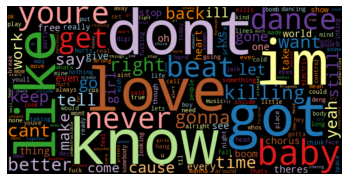

In [25]:
# Build Word Clouds for All Corpuses
print('''Robyn's Lyrics Word Cloud''')
wordcloud(robyn_lyrics.freq)

Cher's Lyrics Word Cloud


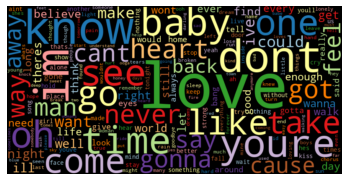

In [26]:
print('''Cher's Lyrics Word Cloud''')
wordcloud(cher_lyrics.freq)

Robyn's Twitter Word Cloud


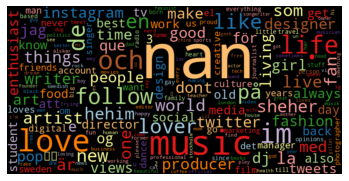

In [27]:
print('''Robyn's Twitter Word Cloud''')
wordcloud(robyn_twitter.freq)

Cher's Lyrics Word Cloud


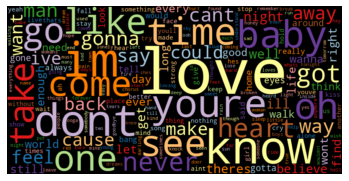

In [28]:
print('''Cher's Lyrics Word Cloud''')
wordcloud(cher_lyrics.freq)

Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: Across all word clouds for both Cher and Robyn, they all share some high frequency words such as `love`, `baby`, `dont`, `know`, etc. Cher's lyrics cloud looks less than the other three word clouds as it doesn't have as much density or maybe less variance of words.